In [128]:
# computer algebra library
# import symengine
import sympy

# numeric integration library
import scipy
from scipy.integrate import solve_ivp

# plotting library
from matplotlib.pyplot import plot,show,legend,xlabel,ylabel,title

# library for scientific computing, used here for plotting
import numpy

# hyperbolic functions
# from mpmath import tanh, mp

from IPython.display import Image

from customDisplays import *

from customSubstitutions import *

# Model

In [2]:
from model import *

blockDisplay('Equations (1)',)
blockDisplay(*(model.equations[e] for e in [Gp, Gt, G]))

blockDisplay('Endogenous Glucose Production (Equation (10))',)
blockDisplay(*(model.equations[e] for e in [EGP]))

blockDisplay('Glucose rate of appearance (Equation (13))',)
blockDisplay(*(model.equations[e] for e in [Qsto, Qsto1, Qsto2, Qgut, Ra]))

blockDisplay('Kempt (Equation (8) from [Dalla Man et al. 2006])',)
blockDisplay(*(model.equations[e] for e in [kempt]))

blockDisplay('Glucose utilization (Equations (14) (15) (18) and (19))',)
blockDisplay(*(model.equations[e] for e in [Uii,Uid,X,U]))

blockDisplay('Insulin secretion (Equations (23) (24) (25) and (26)',)
blockDisplay(*(model.equations[e] for e in [S,Ipo,Y,Spo]))

blockDisplay('Glucose renal excretion (Equation (27)',)
blockDisplay(model.equations[E])

blockDisplay('Insulin subsytem (Equations (3), (11))',)
blockDisplay(*(model.equations[e] for e in [Il,Ip,I,I1,Id]))

blockDisplay('Hepatic extraction (Equations (4), (5))')
blockDisplay(*(model.equations[e] for e in [HE, m3]))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

**Caution**: the constant K_mx is not given any value in the paper... (if I understand correctly, parameter estimation infers a value of 0).  
Note also that in the book "Modelling methodology for Physiology and Madicine", another (more complex...) equation is given for Uid that doesn't use Kmx.

## Initial conditions

Values of the variables at t=0. Note that only the variables defined by a differential equation need to be given  initial conditions explicitly. The initial conditions of the other variables are implicitly obtained by their equation. 

In [5]:
model.initial_conditions = {
    Gp   : Gpb,  # eq (1)
    Gt   : Gtb,  # eq (1)
    G    : Gb,   # eq (1)
    EGP  : EGPb, # eq (10)
    Il   : Ilb,  # eq (3)
    Ip   : Ipb,  # eq (3)
    I    : Ib,   # eq (3)
    I1   : Ib,   # eq (11)
    Id   : Ib,   # eq (11)
    HE   : HEb,  # eq (4)
    Qsto : 0,    # eq (13)
    Qsto1: 0,    # eq (13)
    Qsto2: 0,    # eq (13)
    Qgut : 0,    # eq (13)
    Ra   : 0,    # eq (13)
    X    : 0,    # eq (18)
    Y    : 0,    # eq (26)
    Ipo  : Ipob,  # eq (24)
    D    : 90000
}

The initial conditions depending on basal values, in order to solve the ODEs we first need to analyze to system at steady state. 

# Steady state analysis

Bellow is an attempt to make our own steady state analysis. We succeed but obtain very complex (symbolic) basal values. One reason is probably that we don't consider this assumption that "the liver is responsible for 60% of insulin clearance in the steady state" that led, in the paper, to the equation (9).

In order to determine the initial conditions we need to infer the basal fluxes.
We just fix the amount ingested of glucose as 0. The other input variables (body weight) will subsequently be deleted. In the paper [Dalla Man et al. 2019], the authors give equations to infer the steady state values. Here, we first perform our own steady state analysis to infer these values. Then, we solve the equations given in the paper and finally compare the resulted values.  

In [6]:
from steadyState import *

model.steady_state = EmptyObject()

In [7]:
model.steady_state = init_steady_state_analysis()

In [8]:
generate_steady_state_eqns(model.steady_state)

In [10]:
generate_symbolic_basal_values(model.steady_state)

# Parameters values

- The values for the parameters b and c used in the equation for kempt are difficult to find: in the [Dalla Man et al. 2007] paper (TABLE 1) there are 4 parameters (a,b,c,d) where I chose b and d to match, resp. b and c here (indeed, IMO these should be dimensionless).
- I assume that the value of Kmx is 0 (cite: "Note that, when fitting on our data [...] Kmx collapses to zero so that Km is no more dependent from X")
- according to  [Dalla Man et al. 2007] (p 1745) : "h has been set to the basal glucose concentration Gb to guarantee system steady state in basal condition"
- We define a set of parameters RYGB that is equal to the diabetic ones except for the fraction of intestinal absorption which actually appears in the plasma. This the parameter f that we decrease to 50% (instead of 90%).

Here I use `imp` module to force reloading the parameter values if they are modified.

In [66]:
import imp
imp.reload(parametersValues)
from parametersValues import parameter_values 

In [67]:
for subject in parameter_values.keys():
    blockDisplay(subject,)
    display(parameter_values[subject])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Verification

Evaluating HEb for the normal values of the parameters given in the paper, we obtain a value close to 0.6 given in Table 1 of the paper! (h is fixed to Gb that is about 100/VG for normal subject and 160/VG for diabetic subject as depicted in top left curves of Fig 5)

In [70]:
#print("HEb for normal parameter values: " + 
#    str(sympy.N(model.steady_state.symbolic_basal_values[HEb].subs(parameter_values['normal']).subs(Gpb,90))))
#print("HEb for diabetic parameter values: " + 
#    str(sympy.N(model.steady_state.symbolic_basal_values[HEb].subs(parameter_values['diabetic']).subs(Gpb,160))))
#print("HEb for RYGB parameter values: " + 
#    str(sympy.N(model.steady_state.symbolic_basal_values[HEb].subs(parameter_values['RYGB']).subs(Gpb,160))))

### Numerical basal (normal and diabetic) values

We fix the numerical values of the variables at steady state for both normal and diabetic subjects: 

In [77]:
model.steady_state.numeric_basal_values = dict()
#for subject in ['normal', 'diabetic', 'RYGB_A', 'RYGB_B', 'RYGB_B']:
for subject in parameter_values.keys():
    model.steady_state.numeric_basal_values[subject] = dict()
    for k in list(model.steady_state.symbolic_basal_values.keys()):
        if type(model.steady_state.symbolic_basal_values[k]) != int:
            model.steady_state.\
            numeric_basal_values[subject].\
            update({k:sympy.N(subs(model.steady_state.symbolic_basal_values[k],parameter_values[subject]))})

In [78]:
model.steady_state.numeric_basal_values['normal']

In [79]:
model.steady_state.numeric_basal_values['diabetic']

In [80]:
model.steady_state.numeric_basal_values['RYGB_A']

In [81]:
model.steady_state.numeric_basal_values['RYGB_B']

In [82]:
model.steady_state.numeric_basal_values['RYGB_C']

# Numerical integration

Set of variables that will be integrated:

In [83]:
numerical_simulation = EmptyObject()
numerical_simulation.variables = set(model.symbols.variables)
numerical_simulation.variables

Equations where all symbolic parameters are replaced by a numerical value. We first use the values for normal subjects. 

In [85]:
values = {
    subject : parameter_values[subject].copy()
    for subject in parameter_values.keys()
}

for subject in parameter_values.keys():
    values[subject].update({h: parameter_values[subject][Gb]})

numerical_simulation.numeric_equations = dict()
for subject in parameter_values.keys(): 
    numerical_simulation.numeric_equations[subject] = model.equations.copy()
    numerical_simulation.numeric_equations[subject] = subs(numerical_simulation.numeric_equations[subject],
                                                           values[subject])
    numerical_simulation.numeric_equations[subject] = subs(numerical_simulation.numeric_equations[subject],
                                                           model.steady_state.numeric_basal_values[subject])
    numerical_simulation.numeric_equations[subject].update({D : sympy.Eq(D.diff(),0)})
numerical_simulation.variables.add(D)

In [42]:
#values = {
#    subject : parameter_values[subject].copy()
#    for subject in ['normal', 'diabetic', 'RYGB_A', 'RYGB_B', 'RYGB_C']
#}

#for subject in ['normal', 'diabetic', 'RYGB_A', 'RYGB_B', 'RYGB_C']:
#    values[subject].update({h: parameter_values[subject][Gb]})

#numerical_simulation.numeric_equations = dict()
#for subject in ['normal', 'diabetic', 'RYGB']: 
#    numerical_simulation.numeric_equations[subject] = model.equations.copy()
#    numerical_simulation.numeric_equations[subject] = subs(numerical_simulation.numeric_equations[subject],
#                                                           values[subject])
#    numerical_simulation.numeric_equations[subject] = subs(numerical_simulation.numeric_equations[subject],
#                                                           model.steady_state.numeric_basal_values[subject])
#    numerical_simulation.numeric_equations[subject].update({D : sympy.Eq(D.diff(),0)})
#numerical_simulation.variables.add(D)

We remove algebraic equations and keep only differential equations. We use a fonction that substitutes variables defined by an algebraic equation by the RHS of its definition.

In [86]:
def remove_alg_eq(var, eqs):
    eqs.update({ k : eqs[k].subs(var,eqs[var].rhs) for k in eqs.keys() })
    del eqs[var]

In [87]:
only_diff_equations = dict()
for subject in parameter_values.keys():
    only_diff_equations[subject] = numerical_simulation.numeric_equations[subject].copy()
#only_diff_equations['normal'] = numerical_simulation.numeric_equations['normal'].copy()
#only_diff_equations['diabetic'] = numerical_simulation.numeric_equations['diabetic'].copy()
#only_diff_equations['RYGB'] = numerical_simulation.numeric_equations['RYGB'].copy()
for subject in parameter_values.keys():
    for v in [E,EGP,G,HE,I,kempt,Qsto,Ra,S,Spo,U,Uid,Uii,m3]:
         remove_alg_eq(v,only_diff_equations[subject])

A derivative (d/dt Gp) remains in the equation of Ipo. This is problematic for the numerical integration, so we substitute it by the rhs of the equation for Gp. We have to do it by hand, that is we walk through the syntactic expression and reconstruct it with the substituted term.

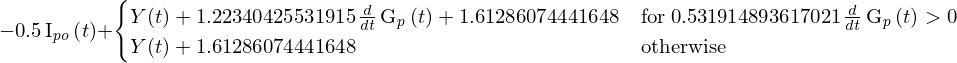

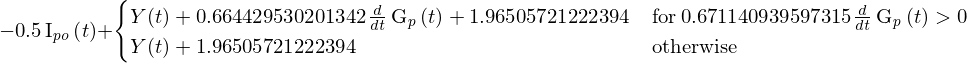

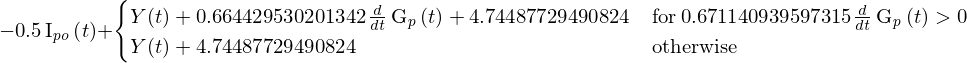

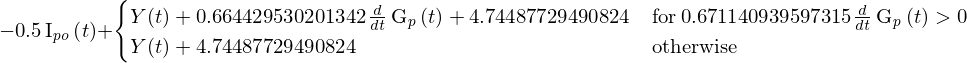

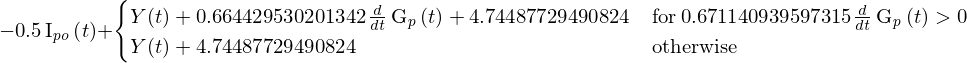

In [88]:
term = dict()
#for subject in ['normal','diabetic','RYGB']:
for subject in parameter_values.keys():
    term[subject] = only_diff_equations[subject][Ipo].rhs.doit()
    display(term[subject])

In [89]:
for subject in parameter_values.keys():
    only_diff_equations[subject].update({Ipo : 
        only_diff_equations[subject][Ipo].doit().subs(Gp.diff(),only_diff_equations[subject][Gp].rhs)
    })

In [ ]:
# dGp = dict()
# first_value = dict()
# second_value = dict()
# new_term = dict()
# for subject in ['normal','diabetic','RYGB']:
#     dGp[subject] = only_diff_equations[subject][Gp].rhs.simplify()
#     first_value[subject] = term[subject].args[1].args[0][0].args[1].args[0]
#     second_value[subject] = term[subject].args[1].args[0][0].args[0]
#     new_term[subject] = (Y + first_value[subject] * dGp[subject] + second_value[subject]).simplify()
#     display(new_term[subject])

In [ ]:
# new_new_term = dict()
# for subject in ['normal','diabetic','RYGB']:
#     new_new_term[subject] = term[subject].args[1].func(term[subject].args[1].args[0].func(new_term[subject],dGp[subject]>0),
#                                                    term[subject].args[1].args[1]).simplify()
#     blockDisplay(new_new_term[subject])

In [ ]:
# for subject in ['normal','diabetic','RYGB']:
#     only_diff_equations[subject].update({Ipo: sympy.Eq(Ipo,term[subject].func(term[subject].args[0],new_new_term[subject]))})

Let's simplify the whole ODE:

In [90]:
for subject in parameter_values.keys():
    for k in list(only_diff_equations[subject].keys()):
        only_diff_equations[subject].update({k:only_diff_equations[subject][k].simplify()})
#only_diff_equations

In [91]:
eq_vars = tuple(only_diff_equations['normal'].keys())
display(eq_vars)

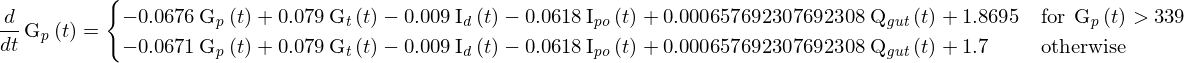

In [92]:
only_diff_equations['normal'][Gp]

Let's replace Dirac function by a sigmoïde (because DiracDelta is apparently not supported by lambdify...)

We use, this function (we don't mind if it's not zero for negative values of t):

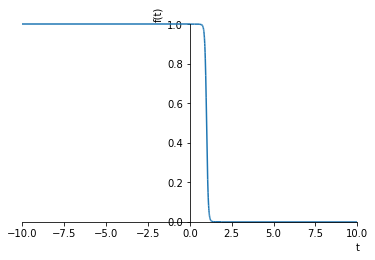

In [93]:
sympy.plotting.plot((0.5 - sympy.tanh(10*(t-1))/2))

And it is crucial to check that this function integrates to 1 for t>0 (similarly to Dirac function): 

In [94]:
import mpmath
ma_sigmoid = lambda x: 0.5 - sympy.tanh(10*(x-1))/2
mpmath.quad(ma_sigmoid, [0, 10])

mpf('1.0000000036599817')

In [95]:
from sympy import DiracDelta
eqnf = { subject : tuple(
                       sympy.lambdify(
                         (t,) + eq_vars,
                          only_diff_equations[subject][ev].args[1].\
                           subs(DiracDelta(t),(0.5 - sympy.tanh(10*(abs(t)-1))/2)),
                           modules='sympy'
                        ) for ev in eq_vars
                   ) for subject in parameter_values.keys()
       }

In [105]:
def numsys_normal(t, y, *kargs, **kwargs): return [eqn(t, *y) for eqn in eqnf['normal']]
def numsys_diabetic(t, y, *kargs, **kwargs): return [eqn(t, *y) for eqn in eqnf['diabetic']]
def numsys_RYGB_A(t, y, *kargs, **kwargs): return [eqn(t, *y) for eqn in eqnf['RYGB_A']]
def numsys_RYGB_B(t, y, *kargs, **kwargs): return [eqn(t, *y) for eqn in eqnf['RYGB_B']]
def numsys_RYGB_C(t, y, *kargs, **kwargs): return [eqn(t, *y) for eqn in eqnf['RYGB_C']]

In [106]:
initial_conditions = dict()
for subject in parameter_values.keys():
    initial_conditions[subject] = \
        tuple(
               (
                 model.initial_conditions[ev] 
                 if (type(model.initial_conditions[ev]) == int)
                 else model.steady_state.numeric_basal_values[subject][model.initial_conditions[ev]]
               ) for ev in eq_vars
            )
#initial_conditions

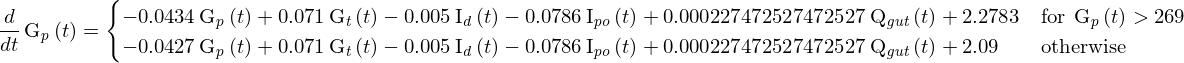

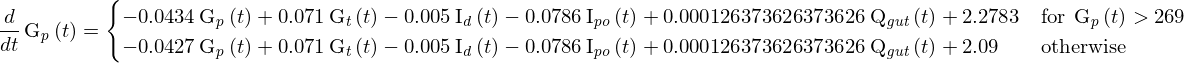

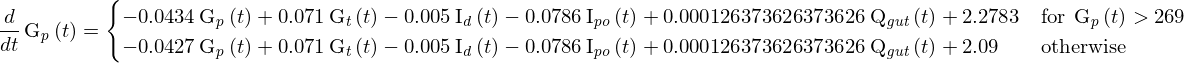

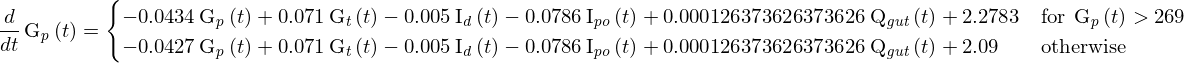

In [103]:
display(only_diff_equations['diabetic'][Gp])
display(only_diff_equations['RYGB_A'][Gp])
display(only_diff_equations['RYGB_B'][Gp])
display(only_diff_equations['RYGB_C'][Gp])

## Simulations

In [116]:
interv = [0, 300]
xp = scipy.linspace(*interv, 100)
sol_normal = solve_ivp(numsys_normal, interv, initial_conditions['normal'], method="LSODA")
sol_diabetic = solve_ivp(numsys_diabetic, interv, initial_conditions['diabetic'], method="LSODA")
sol_rygb_a = solve_ivp(numsys_RYGB_A, interv, initial_conditions['RYGB_A'], method="LSODA")
sol_rygb_b = solve_ivp(numsys_RYGB_B, interv, initial_conditions['RYGB_B'], method="LSODA")
sol_rygb_c = solve_ivp(numsys_RYGB_C, interv, initial_conditions['RYGB_C'], method="LSODA")

#### Plasma Glucose G(t)

* normal = blue
* DT2 = orange
* RYGB = green

In the following plots we observe no qualitative change between DT2 and RYGB: the curves differ only by their amplitude. Transforming DT2 to normal (non diabetic) curve requires a shift in time in addition to shrinking the amplitude. => changing f alone is not sufficient. RYGB may have other physiological impact like brain signal (is it what is called "anticipated insulin signal" in Dalla Man's paper ?).   
Occurding to the equations, decreasing BW (say by half) would have the same effect as decreasing f (see equation for Ra(t)).

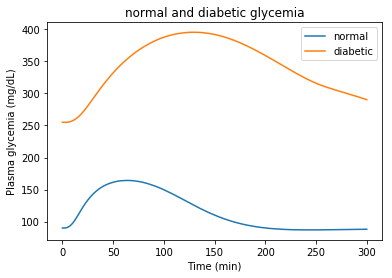

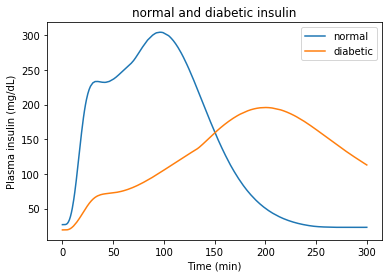

In [131]:
plot(sol_normal.t, sol_normal.y[0]/parameter_values['normal'][VG])
plot(sol_diabetic.t, sol_diabetic.y[0]/parameter_values['diabetic'][VG])
legend(['normal', 'diabetic'])
ylabel('Plasma glycemia (mg/dL)')
xlabel('Time (min)')
title('normal and diabetic glycemia')
show()

plot(sol_normal.t, sol_normal.y[eq_vars.index(Ip)]/parameter_values['normal'][VI])
plot(sol_diabetic.t, sol_diabetic.y[eq_vars.index(Ip)]/parameter_values['diabetic'][VI])
legend(['normal','diabetic'])
ylabel('Plasma insulin (mg/dL)')
xlabel('Time (min)')
title('normal and diabetic insulin')
show()

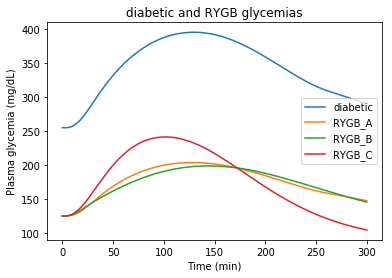

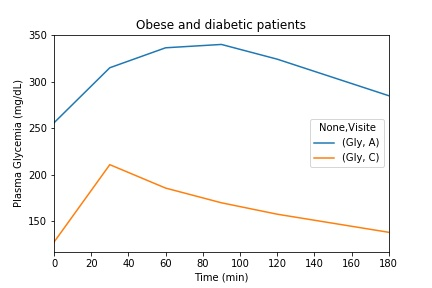

In [137]:
#plot(sol_normal.t, sol_normal.y[0]/parameter_values['normal'][VG])
plot(sol_diabetic.t, sol_diabetic.y[0]/parameter_values['diabetic'][VG])
plot(sol_rygb_a.t, sol_rygb_a.y[0]/parameter_values['RYGB_A'][VG])
plot(sol_rygb_b.t, sol_rygb_b.y[0]/parameter_values['RYGB_B'][VG])
plot(sol_rygb_c.t, sol_rygb_c.y[0]/parameter_values['RYGB_C'][VG])
#legend(['normal','diabetic','RYGB_A','RYGB_B','RYGB_C'])
legend(['diabetic','RYGB_A','RYGB_B','RYGB_C'])
ylabel('Plasma glycemia (mg/dL)')
xlabel('Time (min)')
title('diabetic and RYGB glycemias')
show()
Image(filename = 'obediab_G_AC.jpg')

#### Qsto1(t)


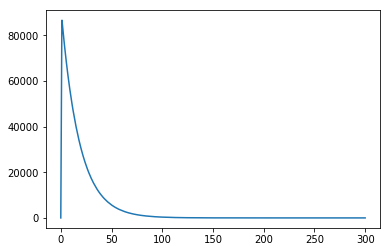

In [118]:
plot(sol_normal.t, sol_normal.y[eq_vars.index(Qsto1)])

#### Glucose rate of appearance Ra(t)

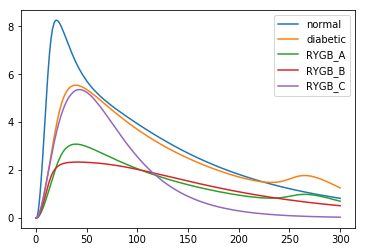

In [120]:
plot(sol_normal.t, parameter_values['normal'][f]*parameter_values['normal'][kabs]*sol_normal.y[eq_vars.index(Qgut)]/parameter_values['normal'][BW])
plot(sol_diabetic.t, parameter_values['diabetic'][f]*parameter_values['diabetic'][kabs]*sol_diabetic.y[eq_vars.index(Qgut)]/parameter_values['diabetic'][BW])
plot(sol_rygb_a.t, parameter_values['RYGB_A'][f]*parameter_values['RYGB_A'][kabs]*sol_rygb_a.y[eq_vars.index(Qgut)]/parameter_values['RYGB_A'][BW])
plot(sol_rygb_b.t, parameter_values['RYGB_B'][f]*parameter_values['RYGB_B'][kabs]*sol_rygb_b.y[eq_vars.index(Qgut)]/parameter_values['RYGB_B'][BW])
plot(sol_rygb_c.t, parameter_values['RYGB_C'][f]*parameter_values['RYGB_C'][kabs]*sol_rygb_c.y[eq_vars.index(Qgut)]/parameter_values['RYGB_C'][BW])
legend(['normal','diabetic','RYGB_A','RYGB_B','RYGB_C'])
show()

#### Plasma insulin I(t)

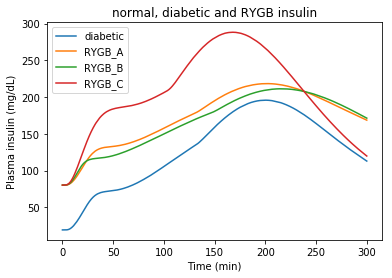

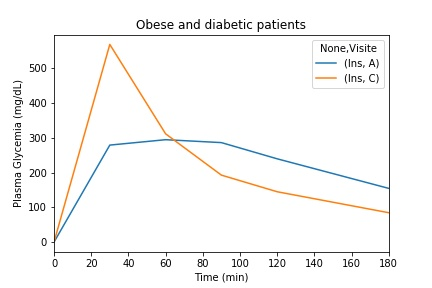

In [138]:
#plot(sol_normal.t, sol_normal.y[eq_vars.index(Ip)]/parameter_values['normal'][VI])
plot(sol_diabetic.t, sol_diabetic.y[eq_vars.index(Ip)]/parameter_values['diabetic'][VI])
plot(sol_rygb_a.t, sol_rygb_a.y[eq_vars.index(Ip)]/parameter_values['RYGB_A'][VI])
plot(sol_rygb_b.t, sol_rygb_b.y[eq_vars.index(Ip)]/parameter_values['RYGB_B'][VI])
plot(sol_rygb_c.t, sol_rygb_c.y[eq_vars.index(Ip)]/parameter_values['RYGB_C'][VI])
legend(['diabetic','RYGB_A','RYGB_B','RYGB_C'])
ylabel('Plasma insulin (mg/dL)')
xlabel('Time (min)')
title('normal, diabetic and RYGB insulin')
show()
Image(filename = 'obediab_I_AC.jpg')

#### Endogenous glucose production EGP(t)

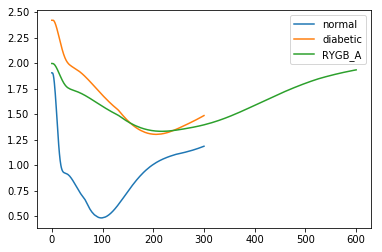

In [140]:
plot(sol_normal.t, parameter_values['normal'][kp1]-parameter_values['normal'][kp2]*sol_normal.y[eq_vars.index(Gp)]
             -parameter_values['normal'][kp3]*sol_normal.y[eq_vars.index(Id)]
             -parameter_values['normal'][kp4]*sol_normal.y[eq_vars.index(Ipo)])
plot(sol_diabetic.t, parameter_values['diabetic'][kp1]-parameter_values['diabetic'][kp2]*sol_diabetic.y[eq_vars.index(Gp)]
             -parameter_values['diabetic'][kp3]*sol_diabetic.y[eq_vars.index(Id)]
             -parameter_values['diabetic'][kp4]*sol_diabetic.y[eq_vars.index(Ipo)])
plot(sol_rygb.t, parameter_values['RYGB_A'][kp1]-parameter_values['RYGB_A'][kp2]*sol_rygb.y[eq_vars.index(Gp)]
             -parameter_values['RYGB_A'][kp3]*sol_rygb.y[eq_vars.index(Id)]
             -parameter_values['RYGB_A'][kp4]*sol_rygb.y[eq_vars.index(Ipo)])
legend(['normal','diabetic','RYGB_A'])
show()

#### Insulin secretion S(t)

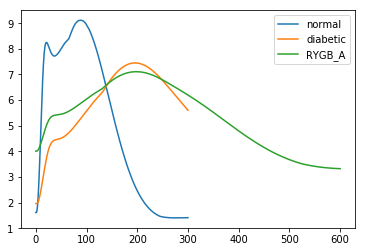

In [141]:
plot(sol_normal.t, sol_normal.y[eq_vars.index(Ipo)]*parameter_values['normal'][γ])
plot(sol_diabetic.t, sol_diabetic.y[eq_vars.index(Ipo)]*parameter_values['diabetic'][γ])
plot(sol_rygb.t, sol_rygb.y[eq_vars.index(Ipo)]*parameter_values['RYGB_A'][γ])
legend(['normal','diabetic','RYGB_A'])
show()

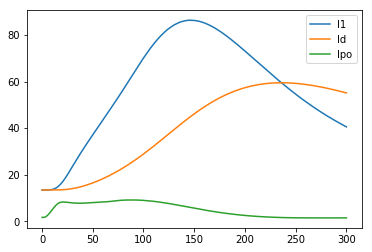

In [143]:
plot(sol_normal.t, sol_normal.y[eq_vars.index(I1)]*parameter_values['normal'][γ])
plot(sol_normal.t, sol_normal.y[eq_vars.index(Id)]*parameter_values['normal'][γ])
plot(sol_normal.t, sol_normal.y[eq_vars.index(Ipo)]*parameter_values['normal'][γ])
legend(['I1','Id', 'Ipo'])

# [OBSOLETE] Comparison with clinical data (mixed meal test)

In [ ]:
import csv
import locale
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')

### Comparison between simulation and data for normal subject

We extract glucose data of non-diabetic patients before operation.

In [ ]:
data = []
with open('../Pattou_data/repasTests.csv', encoding="ISO-8859-1", newline='') as csvfile:
        reader = csv.DictReader(csvfile, delimiter=';')
        #try:
        for row in reader:
                data_row = []
                try:
                    if (row['visite_mois'] == '0,00') and (row['diabete'] == '0,00'):
                       data_row = [locale.atof(row['mmtt-glyc'+x+'_mg_dl']) for x in ['0', '30', '60', '90', '120', '180']]
                       data_row.insert(0,locale.atof(row['num_obese']))
                       data.append(data_row)
                except:
                    print('skip: ' + row['num_obese'])

Remove empty data rows:

In [ ]:
data = [x for x in data if x != []]

In [ ]:
data

In [ ]:
def display_data_diabetic(num):
    plot(sol_diabetic.t, sol_diabetic.y[0]/model.parameter_values['diabetic'][VG])
    plot([0,30,60,90,120,180], data[num][1:], linestyle = 'none', marker = 'o')
    print('num_obese = '+str(data[num][0]))

In [ ]:
def display_data_normal(num):
    plot(sol_normal.t, sol_normal.y[0]/model.parameter_values['normal'][VG])
    plot([0,30,60,90,120,180], data[num][1:], linestyle = 'dashed', marker = 'o')
    print('num_obese = '+str(data[num][0]))

In [ ]:
for i in range(0,len(data)):
    plot(sol_normal.t, sol_normal.y[0]/model.parameter_values['normal'][VG])
    plot([0,30,60,90,120,180], data[i][1:], linestyle = 'dashed', marker = 'o')
    legend(['simulation', 'num_obese = '+str(data[i][0])])
    show()

### Comparison between simulation and data for diabetic subject

In [ ]:
data = []
with open('../Pattou_data/repasTests.csv', encoding="ISO-8859-1", newline='') as csvfile:
        reader = csv.DictReader(csvfile, delimiter=';')
        #try:
        for row in reader:
                data_row = []
                try:
                    if (row['visite_mois'] == '0,00') and (row['diabete'] == '1,00'):
                       data_row = [locale.atof(row['mmtt-glyc'+x+'_mg_dl']) for x in ['0', '30', '60', '90', '120', '180']]
                       data_row.insert(0,locale.atof(row['num_obese']))
                       data.append(data_row)
                except:
                    print('skip: ' + row['num_obese'])

In [ ]:
data = [x for x in data if x != []]
data

In [ ]:
for i in range(0,len(data)):
    #plot(sol_diabetic.t, sol_diabetic.y[0]/model.parameter_values['diabetic'][VG])
    plot(sol_normal.t, sol_normal.y[0]/model.parameter_values['normal'][VG])
    plot([0,30,60,90,120,180], data[i][1:], linestyle = 'dashed', marker = 'o')
    legend(['simulation', 'num_obese = '+str(data[i][0])])
    show()

### Compararison of data before and after RYGB for diabetic subjects

In [ ]:
data = {'before' : dict(), 'after' : dict()}
with open('../Pattou_data/repasTests.csv', encoding="ISO-8859-1", newline='') as csvfile:
        reader = csv.DictReader(csvfile, delimiter=';')
        #try:
        for row in reader:
                data_row = []
                try:
                    if (row['visite_mois'] == '0,00') and (row['diabete'] == '1,00') and (row['type operation'] == '1,00'):
                       data_row = [locale.atof(row['mmtt-glyc'+x+'_mg_dl']) for x in ['0', '30', '60', '90', '120', '180']]
                       #data_row.insert(0,locale.atof(row['num_obese']))
                       data['before'].update({row['num_obese']: data_row})
                except:
                    print('skip: ' + row['num_obese'])
with open('../Pattou_data/repasTests.csv', encoding="ISO-8859-1", newline='') as csvfile:
        reader = csv.DictReader(csvfile, delimiter=';')
        for row in reader:
                data_row = []
                try:
                    if (row['visite_mois'] == '3,00') and (row['diabete'] == '1,00') and (row['type operation'] == '1,00'):
                       data_row = [locale.atof(row['mmtt-glyc'+x+'_mg_dl']) for x in ['0', '30', '60', '90', '120', '180']]
                       #data_row.insert(0,locale.atof(row['num_obese']))
                       data['after'].update({row['num_obese']: data_row})
                except:
                    print('skip: ' + row['num_obese'])

In [ ]:
data

In [ ]:
for num in data['before'].keys():
    if num in data['after'].keys():
       print(num)
       #plot([0,30,60,90,120,180], data['before'][num], marker = 'o')
       #plot([0,30,60,90,120,180], data['after'][num], marker = 'o')
    legend(['before', 'after'])
    show()